In [2]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 799.2 kB/s eta 0:02:36
   ---------------------------------------- 0.5/124.9 MB 799.2 kB/s eta 0:02:36
   ---------------------------------------- 0.8/124.9 MB 799.2 kB/s eta 0:02:36
   ---------------------------------------- 1.3/124.9 MB 1.1 MB/s eta 0:01:49
    --------------------------------------- 1.6/124.9 MB 1.2 MB/s eta 0:01:45
    --------------------------------------- 2.1/124.9 MB 1.3 MB/s eta 0:01:33
    --------------------------------------- 2.4/124.9 MB 1.4 MB/s eta 0:01:30
    --------------------------------------- 2.9/124.9 MB 1.5 MB/s eta 0:01:21
   - -------------------------------------- 3.4/124.9 MB 1.6 MB/s eta 0:01:15
   - ---

Model saved as xgb_model_temp_vs_h2.pkl
Analysis for temp_vs_h2.csv:
Mean Squared Error (MSE): 7.205647107497822e-09
R² Score: 0.9995654314057011



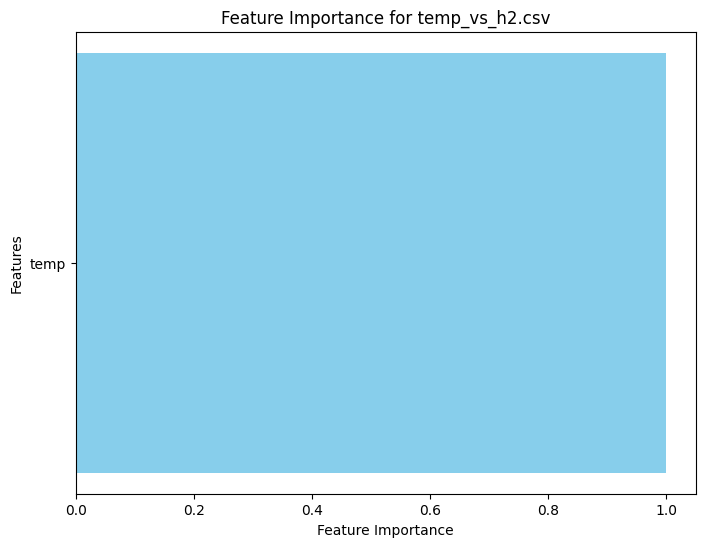

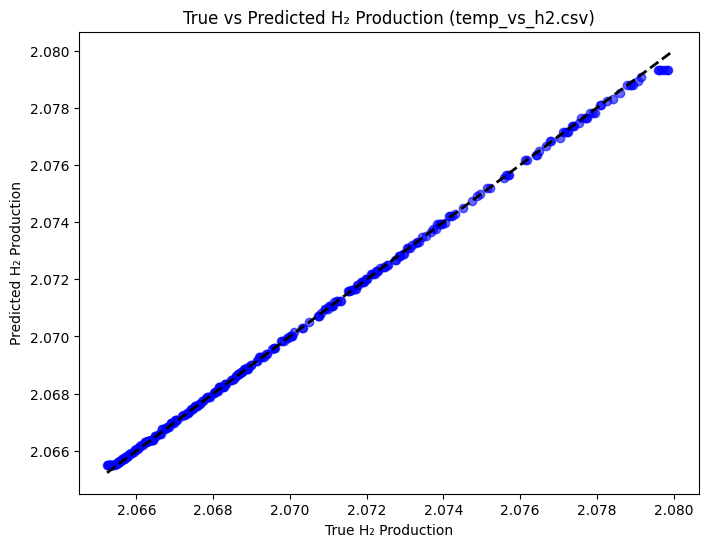

Model saved as xgb_model_press_vs_h2.pkl
Analysis for press_vs_h2.csv:
Mean Squared Error (MSE): 4.2755685645472565e-10
R² Score: -0.00011841689082259244



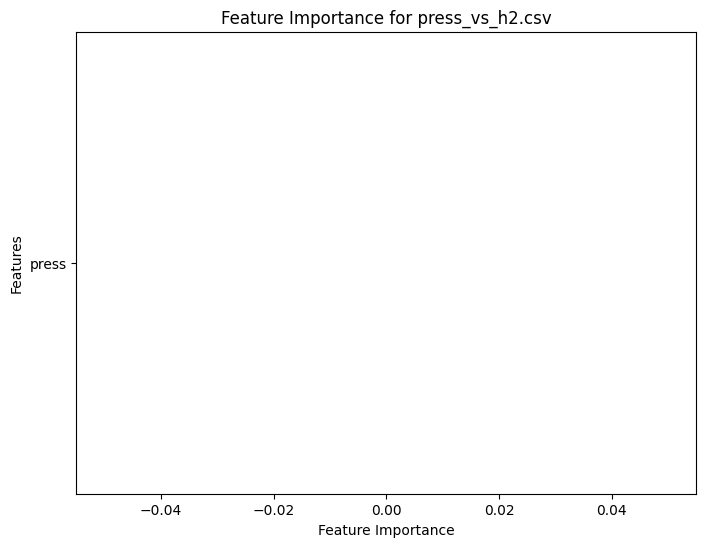

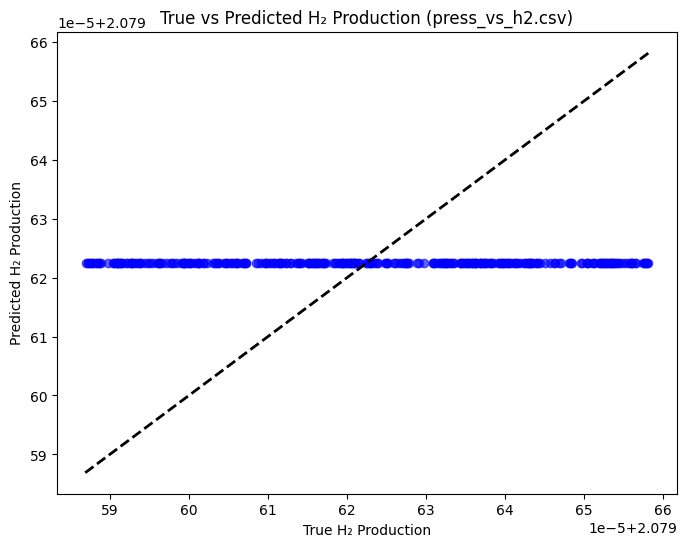

Model saved as xgb_model_temp_press_vs_h2.pkl
Analysis for temp_press_vs_h2.csv:
Mean Squared Error (MSE): 1.316002502055893e-09
R² Score: 0.9999230856674248



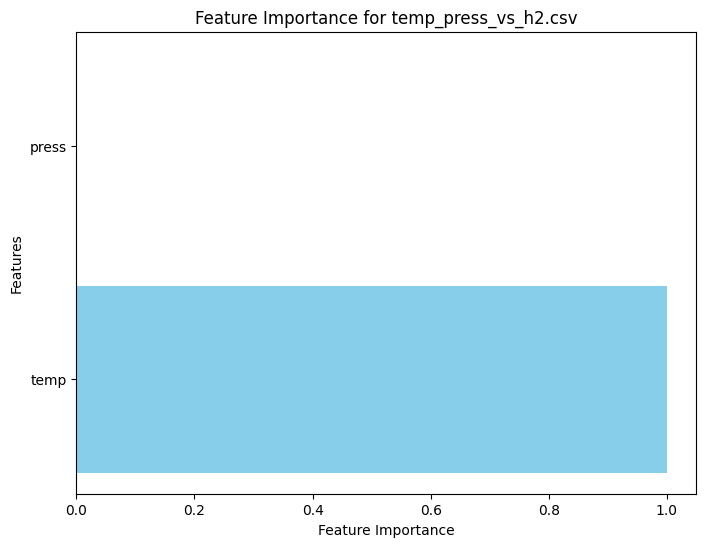

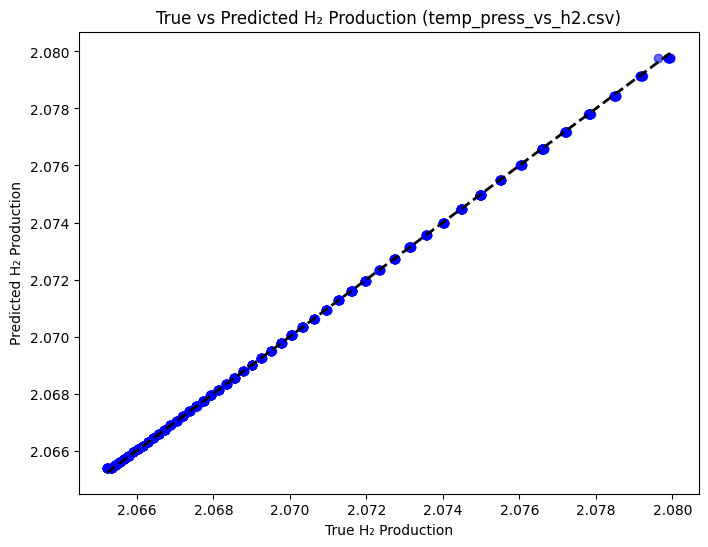

Model saved as xgb_model_biogas_mass_vs_h2.pkl
Analysis for biogas_mass_vs_h2.csv:
Mean Squared Error (MSE): 1.2640424224376042e-05
R² Score: 0.9999188460299484



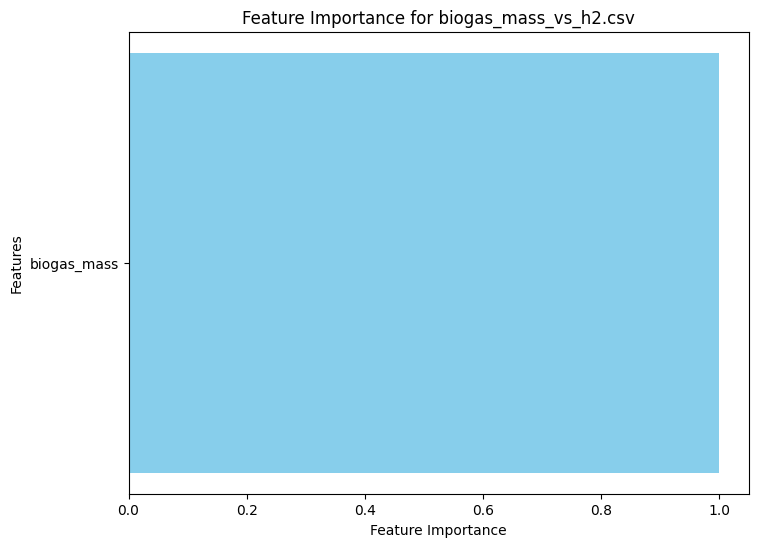

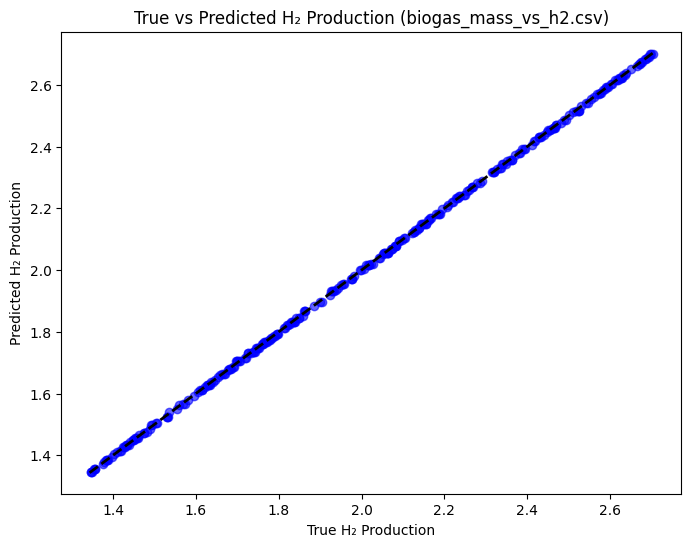

In [5]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt

# Function to load data, train XGBoost model, and evaluate results
def analyze_xgboost(data_path, features, target):
    # Load data
    data = pd.read_csv(data_path)
    
    # Split data into features (X) and target (y)
    X = data[features]
    y = data[target]
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize and train XGBoost Regressor
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, objective='reg:squarederror')
    xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Create the model file name by replacing .csv with .pkl
    model_filename = f"xgb_model_{data_path.split('/')[-1].replace('.csv', '.pkl')}"
    
    # Save the trained model with .pkl extension
    with open(model_filename, 'wb') as file:
        pickle.dump(xgb, file)
    print(f"Model saved as {model_filename}")
    
    # Make predictions
    y_pred = xgb.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Analysis for {data_path.split('/')[-1]}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² Score: {r2}\n")
    
    # Feature importance visualization
    feature_importance = xgb.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(features, feature_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance for {data_path.split("/")[-1]}')
    plt.show()
    
    # True vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('True H₂ Production')
    plt.ylabel('Predicted H₂ Production')
    plt.title(f'True vs Predicted H₂ Production ({data_path.split("/")[-1]})')
    plt.show()

    # Plot the training and test loss using evaluation results
    results = xgb.evals_result()
    if 'validation_0' in results and 'validation_1' in results:
        train_loss = results['validation_0']['rmse']
        test_loss = results['validation_1']['rmse']

        # Plot the training and test loss
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
        plt.plot(test_loss, label='Test Loss', color='orange', marker='o')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Loss (Root Mean Squared Error)')
        plt.title(f'Training and Test Loss Over Boosting Iterations ({data_path.split("/")[-1]})')
        plt.legend()
        plt.grid(True)
        plt.show()


# Define the datasets and features
datasets = {
    "temp_vs_h2.csv": ["temp"],
    "press_vs_h2.csv": ["press"],
    "temp_press_vs_h2.csv": ["temp", "press"],
    "biogas_mass_vs_h2.csv": ["biogas_mass"]
}

# Perform analysis for each dataset
for file, features in datasets.items():
    analyze_xgboost(data_path=file, features=features, target="h2_production")
